## Movielens分析
#### データセットダウンロード

In [1]:
import glob
import pandas as pd
import collections
import re

In [2]:
%%bash
cd ../datasets
rm -r ml-20m*
curl -O 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
unzip ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189M  100  189M    0     0  49.3M      0  0:00:03  0:00:03 --:--:-- 49.3M


In [3]:
files = glob.glob('../datasets/ml-20m/*.csv')
keys = [file.split("/")[-1].strip(".csv") for file in files]
# 何故かkeyの中にある's'も消去されてしまう... とりあえずこのままで
print("df_dict: {}".format(keys))
df_dict = {key:value for key, value in zip(keys, (pd.read_csv(f) for f in files))}

df_dict: ['link', 'genome-score', 'movie', 'rating', 'genome-tag', 'tag']


In [4]:
for key, df in df_dict.items():
    print(key)
    print(df)
    print("=" * 100)

movie
       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
27273   131254        Kein Bund für's Leben (2007)   
27274   131256       Feuer, Eis & Dosenbier (2002)   
27275   131258                  The Pirates (2014)   
27276   131260                 Rentun Ruusu (2001)   
27277   131262                    Innocence (2014)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                        

## 分析
  * tag, title(year), genre, ratingに分けて分析してみる
  * tag系はrelevanceを使いたいので、tag.csvではなくtag-genomeとscore-genomeを使う

#### tag

In [5]:
df_tag = pd.merge(df_dict['genome-tag'], df_dict['genome-score'], on='tagId')
df_tag = pd.merge(df_tag, df_dict['movie'].loc[:,['movieId','title']], on='movieId')
df_tag = df_tag.loc[:, ['title', 'tag', 'relevance']]
print(df_tag)

                     title           tag  relevance
0         Toy Story (1995)           007    0.02500
1         Toy Story (1995)  007 (series)    0.02500
2         Toy Story (1995)  18th century    0.05775
3         Toy Story (1995)         1920s    0.09675
4         Toy Story (1995)         1930s    0.14675
...                    ...           ...        ...
11709763  Parallels (2015)       writing    0.58775
11709764  Parallels (2015)         wuxia    0.01075
11709765  Parallels (2015)          wwii    0.01575
11709766  Parallels (2015)        zombie    0.11450
11709767  Parallels (2015)       zombies    0.02175

[11709768 rows x 3 columns]


* movieとtagの関係を調べてみる

In [6]:
print(df_tag[df_tag['title'] == 'Toy Story (1995)'].sort_values(by = 'relevance', ascending = False).reset_index(drop=True))

                 title                 tag  relevance
0     Toy Story (1995)                toys    0.99925
1     Toy Story (1995)  computer animation    0.99850
2     Toy Story (1995)     pixar animation    0.99600
3     Toy Story (1995)     kids and family    0.99075
4     Toy Story (1995)           animation    0.98575
...                ...                 ...        ...
1123  Toy Story (1995)                 mtv    0.00375
1124  Toy Story (1995)          james bond    0.00325
1125  Toy Story (1995)     hannibal lecter    0.00225
1126  Toy Story (1995)             swedish    0.00175
1127  Toy Story (1995)             beatles    0.00150

[1128 rows x 3 columns]


* 1つのmovieずつに全てのtagとそれに対するrelevanceがあったので、relevanceが一定以上低い物を除外した方が良さそうだった
* どの程度の割合で除外すれば良さそうか調べるため、　におけるrelevanceの分布を調べてみる

(-0.00075, 0.1]    0.662078
(0.1, 0.2]         0.166301
(0.2, 0.3]         0.072695
(0.3, 0.4]         0.037505
(0.4, 0.5]         0.022173
(0.5, 0.6]         0.013967
(0.6, 0.7]         0.009648
(0.7, 0.8]         0.006845
(0.8, 0.9]         0.004793
(0.9, 1.0]         0.003994
Name: relevance, dtype: float64


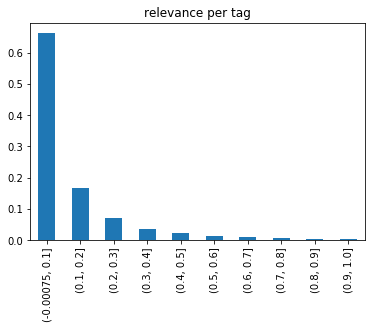

In [7]:
df_rel = pd.cut(df_tag['relevance'], 10).value_counts(normalize=True)
print(df_rel)
df_rel.plot(kind="bar", title='relevance per tag')

* tagの約9.6割がrelevance > 0.5 なのでほとんどのtagはいらなそう
* とりあえず活用する場合tag数の1.5パーセント程(≒17)個あれば良さそう？

#### titleとyearの関係

In [8]:
def movie_title_clean(title):    
  s = re.search('\(([^)]+)', title)
  year = 9999
  if s:
    title = title[:s.span()[0]].strip()
    year = s.group(1)
    # yearが無かったりおかしいものには9999を入れておく
    if str(year).isdigit() and len(year) == 4:
      year = int(year)
    else:
      year = 9999     
  return title, year

In [9]:
df_movie = df_dict['movie']
df_movie['title'] = df_movie['title'].str.strip()
title_year = df_movie['title'].map(movie_title_clean)
title = title_year.apply(lambda x: x[0])
year = title_year.apply(lambda x: x[1]).rename('year')
df = pd.concat([title, year], axis=1)
print(df)

                             title  year
0                        Toy Story  1995
1                          Jumanji  1995
2                 Grumpier Old Men  1995
3                Waiting to Exhale  1995
4      Father of the Bride Part II  1995
...                            ...   ...
27273        Kein Bund für's Leben  2007
27274       Feuer, Eis & Dosenbier  2002
27275                  The Pirates  2014
27276                 Rentun Ruusu  2001
27277                    Innocence  2014

[27278 rows x 2 columns]


1891      1
1893      1
1894      2
1895      2
1896      2
       ... 
2011    850
2012    872
2013    902
2014    701
2015    120
Name: year, Length: 116, dtype: int64


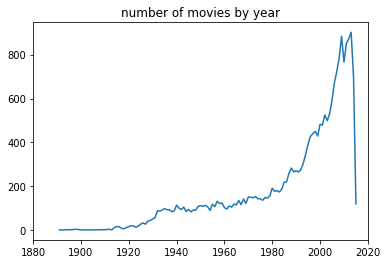

In [10]:
year_count = df['year'].value_counts(sort=False).drop(9999).sort_index()
print(year_count)
year_count.plot(xticks=[1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020], title='number of movies by year')

* 1990年以降の映画の数がかなり多く、古い映画になる程数が少ない

#### movieとgenreの関係

                 genre  count
8                 IMAX    196
15  (no genres listed)    246
18           Film-Noir    330
16             Western    676
19           Animation   1027
0              Musical   1036
7             Children   1139
17                 War   1194
6              Fantasy   1412
4              Mystery   1514
14              Sci-Fi   1743
13           Adventure   2329
3          Documentary   2471
2               Horror   2611
12               Crime   2939
10              Action   3520
5              Romance   4127
9             Thriller   4178
1               Comedy   8374
11               Drama  13344


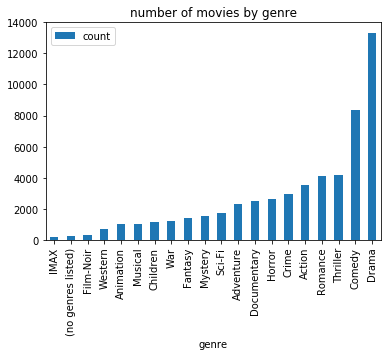

In [11]:
df_movie['genres_list'] = df_movie['genres'].str.split('|')
genres_list = sum(df_movie['genres_list'], [])
c = collections.Counter(genres_list)
df = pd.DataFrame.from_dict(c, orient='index').reset_index().rename(columns={'index':'genre', 0:'count'}).sort_values(by = 'count')
print(df)
df.plot(kind="bar",x=df.columns[0], title='number of movies by genre')

* genreの方がtagより粒度が大きく、ずっと少ない
* genreの方が使い勝手は良さそう

#### movieとratingの関係

In [12]:
df_dict['movie']['title'] = title
df_dict['movie']['year'] = year
df_rating = pd.merge(df_dict['rating'], df_dict['movie'], on='movieId')
print(df_rating)

          userId  movieId  rating   timestamp                        title  \
0              1        2     3.5  1112486027                      Jumanji   
1              5        2     3.0   851527569                      Jumanji   
2             13        2     3.0   849082742                      Jumanji   
3             29        2     3.0   835562174                      Jumanji   
4             34        2     3.0   846509384                      Jumanji   
...          ...      ...     ...         ...                          ...   
20000258  138301   121017     3.5  1420558479     The Gentleman from Epsom   
20000259  138301   121019     4.5  1420558606          The Great Spy Chase   
20000260  138301   121021     4.5  1420558687              Taxi for Tobruk   
20000261  138406   110167     4.5  1396184127  Judge and the Assassin, The   
20000262  138406   110510     4.5  1397597539                  Série noire   

                              genres                     genres

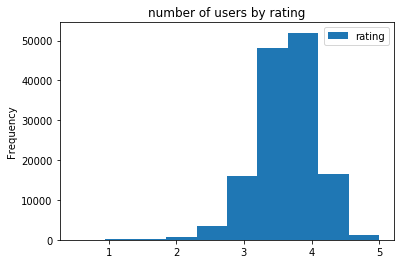

In [13]:
# 各ユーザーがつけるレーティング平均の割合
rating_user_mean = df_rating[['userId','rating']].groupby('userId').mean()
rating_user_mean.plot(kind='hist', title='number of users by rating')

* ユーザーがつけるレーティング平均のほとんどが2.5以上
* 低い評価をつけることがほとんどない

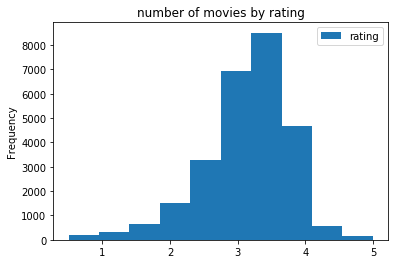

In [14]:
# 各movieのレーティング平均の割合
rating_movie_mean = df_rating[['movieId','rating']].groupby('movieId').mean()
rating_movie_mean.plot(kind='hist', title='number of movies by rating')

* 多くの映画の評価は2~4点の間に収まっている

         No       Yes
0  0.019576  0.980424


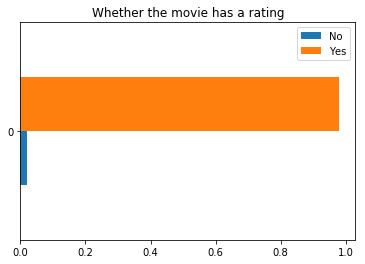

In [15]:
# 評価が存在する映画と存在しない映画の割合
rating_count = len(df_rating['movieId'].unique())
movie_count = len(df_dict['movie']['movieId'].unique())
has_rating = pd.DataFrame(
    {'Yes': [rating_count], 'No': [movie_count - rating_count]}
).apply(lambda x:x/sum(x),axis=1)
print(has_rating)
has_rating.plot(kind="barh", title='Whether the movie has a rating')

* 殆どのmovieにratingはありそう

       rating_num    rating
0           49695  3.921240
1           22243  3.211977
2           12735  3.151040
3            2756  2.861393
4           12161  3.064592
...           ...       ...
26739           1  4.000000
26740           1  4.000000
26741           1  2.500000
26742           1  3.000000
26743           1  4.000000

[26744 rows x 2 columns]


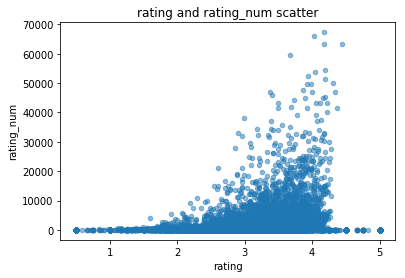

In [16]:
# movie毎のレーティングおよびレートの散布図
movie_rating_num = df_rating['movieId'].value_counts().sort_index()
movie_rating_num = pd.DataFrame(movie_rating_num).reset_index().rename(columns={'index':'movieId', 'movieId':'rating_num'})
rating_movie_mean = df_rating[['movieId','rating']].groupby('movieId').mean()
movie_scatter = pd.merge(movie_rating_num, rating_movie_mean, on='movieId').drop('movieId', axis=1)
print(movie_scatter)
movie_scatter.plot(kind='scatter', x='rating', y='rating_num', alpha=0.5, title='rating and rating_num scatter')

* 高いレーティングのものは評価数も多く、低いレーティングのものは評価数が少ない